# Hello Explainable AI

This basic introduction to [OpenVINO™ Explainable AI (XAI)](https://github.com/openvinotoolkit/openvino_xai/) shows how to explain predictions of an image classification model.

[OpenVINO™ Explainable AI (XAI)](https://github.com/openvinotoolkit/openvino_xai/) provides a suite of XAI algorithms for analysis of model predictions. Generated saliency maps can be used to evaluate model reasoning when making predictions.

A pre-trained [MobileNetV3 model](https://docs.openvino.ai/2024/omz_models_model_mobilenet_v3_small_1_0_224_tf.html) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) is used in this tutorial.


#### Table of contents:

- [Imports](#Imports)
- [Download the Model and data samples](#Download-the-Model-and-data-samples)
- [Load the Model](#Load-the-Model)
- [Load an Image](#Load-an-Image)
- [Do Inference](#Do-Inference)
- [Create Explainer](#Create-Explainer)
- [Do Explanation](#Do-Explanation)

In [ ]:
import platform

# Install openvino package
%pip install -q "openvino>=2023.1.0" opencv-python tqdm

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

%pip install git+https://github.com/negvet/openvino_xai.git@et/fix_visualization

## Imports
[back to top ⬆️](#Table-of-contents:)


In [3]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
import openvino_xai as xai

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file

## Download the Model and data samples
[back to top ⬆️](#Table-of-contents:)


In [ ]:
base_artifacts_dir = Path("./artifacts").expanduser()

model_name = "v3-small_224_1.0_float"
model_xml_name = f"{model_name}.xml"
model_bin_name = f"{model_name}.bin"

model_xml_path = base_artifacts_dir / model_xml_name

base_url = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/mobelinet-v3-tf/FP32/"

if not model_xml_path.exists():
    download_file(base_url + model_xml_name, model_xml_name, base_artifacts_dir)
    download_file(base_url + model_bin_name, model_bin_name, base_artifacts_dir)
else:
    print(f"{model_name} already downloaded to {base_artifacts_dir}")

## Load the Model
[back to top ⬆️](#Table-of-contents:)


In [5]:
core = ov.Core()
model = core.read_model(model=model_xml_path)
compiled_model = core.compile_model(model=model, device_name="CPU")

output_layer = compiled_model.output(0)

## Load an Image
[back to top ⬆️](#Table-of-contents:)


'data/coco.jpg' already exists.


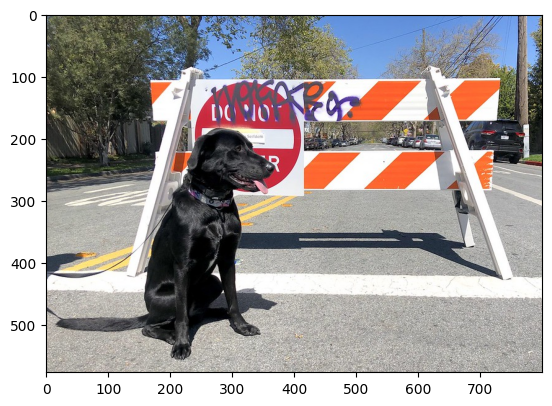

In [6]:
# Download the image from the openvino_notebooks storage
image_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
    directory="data",
)

# The MobileNet model expects images in RGB format.
image = cv2.cvtColor(cv2.imread(filename=str(image_filename)), code=cv2.COLOR_BGR2RGB)

# Resize to MobileNet image shape.
input_image = cv2.resize(src=image, dsize=(224, 224))

# Reshape to model input shape.
input_image = np.expand_dims(input_image, 0)
plt.imshow(image);

## Do Inference
[back to top ⬆️](#Table-of-contents:)

In [7]:
result_infer = compiled_model([input_image])[output_layer]
result_index = np.argmax(result_infer)

In [ ]:
imagenet_filename = download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/datasets/imagenet/imagenet_2012.txt",
    directory="data",
)

imagenet_classes = imagenet_filename.read_text().splitlines()

In [9]:
# The model description states that for this model, class 0 is a background.
# Therefore, a background must be added at the beginning of imagenet_classes.
imagenet_classes = ["background"] + imagenet_classes

result_index, imagenet_classes[result_index], result_infer[0][result_index]

(206, 'n02099267 flat-coated retriever', 0.76442116)

## Create Explainer
[back to top ⬆️](#Table-of-contents:)

In [ ]:
explainer = xai.Explainer(
    model=model,
    task=xai.Task.CLASSIFICATION,
)

## Do Explanation
[back to top ⬆️](#Table-of-contents:)

Explainer generates explanation which contains saliency maps ({target: saliency_map}). For classification, targets are indices of the classes.

Below saliency map can help to answer the question: "Which part of the image mostly contributes to the predictied class: (206, 'n02099267 flat-coated retriever')?"

Text(0.5, 1.0, 'Saliency map of 206 class.')

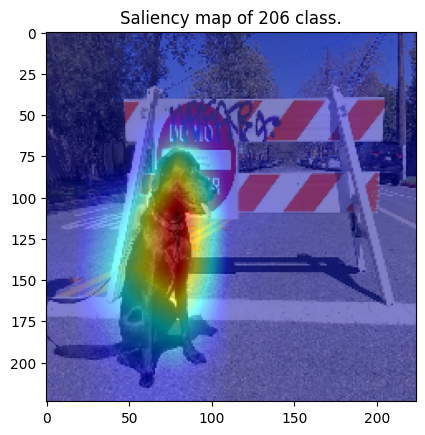

In [11]:
explanation = explainer(
    data=input_image,
    targets=result_index,  # can be a single target or a container of targets
    overlay=True,  # saliency map overlay over the input image, defaults to False
)
plt.imshow(explanation.saliency_map[result_index])
plt.title(f"Saliency map of {result_index} class.")

Save saliency maps for further visual analisys.

In [12]:
explanation.save(base_artifacts_dir)